Make sure everything runs as expected before you submit your notebook. First, **restart the kernel** (Kernel$\rightarrow$Restart) and then **run all cells** (Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and student ID below:

In [2]:
NAME = "Benji van den Brand"
STUDENT_ID = "1328255"

"1328255"

---

# [5SSD0] Probabilistic Programming - Assignment 2

Year: 2023-2024

In this assignment, we will go through the Bayesian model design cycle:

 <img src="figures/modelling-procedure.png" alt="" width="600"> 

In the second part of the assignment, you will continue improving your model. This time, you will adopt a variational Bayesian procedure.

In [3]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using CSV
using DataFrames
using LinearAlgebra
using ProgressMeter
using RxInfer
using Plots
default(label="",
        grid=false, 
        linewidth=3, 
        markersize=4,
        guidefontsize=12, 
        margins=15Plots.pt)

  Activating project at `c:\Github projects\BMLIP\lessons\assignments`


## Problem: Forecasting Air Quality

Many Europeans suspect that the air quality in their city is declining. A [recent study](https://doi.org/10.1016/j.snb.2007.09.060) measured the air quality of a major city in North Italy using an electronic nose. The measurements were made in the middle of the city and reflect urban activity. We will inspect the specific chemical concentrations found and build a model to accurately predict CO for future time points.

![https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds](figures/air-milan-wide.png)

Photograph taken by Claudio Furlan/LaPresse/Zuma Press/Rex/Shutterstock ([link](https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds))

### Data

The data can be found here: https://archive.ics.uci.edu/ml/datasets/Air+Quality. I've done some pre-processing and selected the most important features. In this assignment we will infer parameters in a model of the data and predict air quality in the future. For that purpose, the data has been split into past and future.

In [4]:
past_data = DataFrame(CSV.File("data/airquality_past.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-10T18:00:00,1360.0
2,2004-03-10T19:00:00,1292.0
3,2004-03-10T20:00:00,1402.0
4,2004-03-10T21:00:00,1376.0
5,2004-03-10T22:00:00,1272.0
6,2004-03-10T23:00:00,1197.0
7,2004-03-11T00:00:00,1185.0
8,2004-03-11T01:00:00,1136.0
9,2004-03-11T02:00:00,1094.0


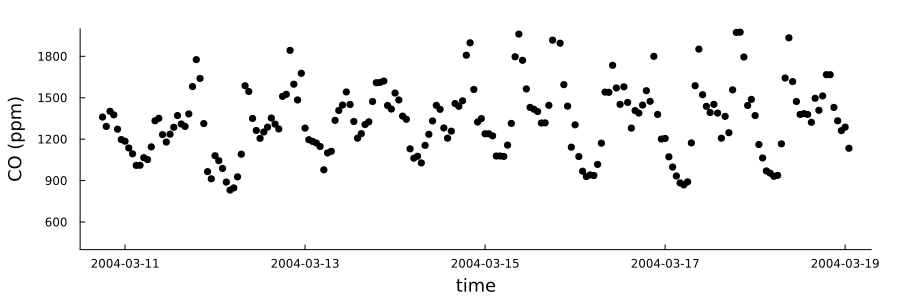

In [4]:
scatter(past_data[:,1], 
        past_data[:,2], 
        size=(900,300), 
        color="black", 
        xlabel="time", 
        ylabel="CO (ppm)",
        ylims=[400,2000])

## 1. Model specification and parameter estimation

In the first assignment, we set the noise level $\tau$ to $1.0$. But that was based on convenience, not on domain expertise or data. We are now going to infer this quantity, simulteanously with the AR coefficients. This requires specifying an appropriate prior probability distribution over $\tau$ and adjusting the inference procedure. 

Tasks:
- [1pt] Infer the approximate posteriors for $\theta$ and $\tau$, for model order $M=2$.
- [1pt] Visualize both posterior distributions, over appropriate ranges.

In [14]:
@model function auto_regression(prior_params; N)
    
    # Prior state
    θ ~ MvNormalMeanCovariance(prior_params[:θ0][1], prior_params[:θ0][2])
    
    # Process noise covariance matrix
    #τ ~ InverseWishart(prior_params[:τ][1], prior_params[:τ][2])
    
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    for i = 1:N
        y[i] ~ NormalMeanVariance(dot(θ,X[i]), τ)
    end
end

# Prior parameters
M = 2

num_samples = length(past_data[:,1])
history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]

# Define prior parameters
prior_params = Dict(:θ0 => (zeros(M), diageye(M)),
                    :τ  => (10, diageye(M)))

# Initialize variational marginal distributions and messages
inits = Dict(:θ => MvNormalMeanCovariance(zeros(M), diageye(M)),
             :τ => InverseWishart(10, diageye(M)))

results = inference(
    model           = auto_regression(prior_params, N=num_samples-M), 
    data            = (y = past_data[:,2][M+1:num_samples], X = history), 
    returnvars      = (θ = KeepLast(), τ = KeepLast()), 
    iterations      = 20,
    constraints     = MeanField(),
    initmarginals = inits,
    initmessages  = inits,
    free_energy     = true
)

# Extract posterior weights 
post_θ = results.posteriors[:θ]
post_τ = results.posteriors[:τ]

post_mode_θ = mode(post_θ)
post_std_θ = std(post_θ)

# Draw contour plots of distributions
θ = 1
x1 = range(-1, step=0.01, stop=0.5)
prior_θ = Normal(post_mode_θ[θ], post_std_θ[θ, θ])
p1a = plot(x1, pdf(prior_θ, x1), xlabel="θ1", ylabel="Likelihood", title="Posterior", label="θ1")

θ = 2
x1 = range(1.0, step=0.01, stop=1.5)
prior_θ = Normal(post_mode_θ[θ], post_std_θ[θ, θ])
p1b = plot(x1, pdf(prior_θ, x1), xlabel="θ1", ylabel="Likelihood", title="Posterior", label="θ1")

x1 = range(15000, step=100, stop=36000)
p1c = plot(x1, pdf(post_τ, x1), title="Posterior", label="τ")

plot(p1a, p1b, p1c)

MethodError: MethodError: no method matching NormalMeanVariance(::Float64, ::Matrix{Float64})

Closest candidates are:
  NormalMeanVariance(::T) where T<:Real
   @ ExponentialFamily C:\Users\20181762\.julia\packages\ExponentialFamily\aj69e\src\distributions\normal_family\normal_mean_variance.jl:21
  NormalMeanVariance(::T, !Matched::T) where T<:Real
   @ ExponentialFamily C:\Users\20181762\.julia\packages\ExponentialFamily\aj69e\src\distributions\normal_family\normal_mean_variance.jl:15
  NormalMeanVariance(::Real, !Matched::Real)
   @ ExponentialFamily C:\Users\20181762\.julia\packages\ExponentialFamily\aj69e\src\distributions\normal_family\normal_mean_variance.jl:19


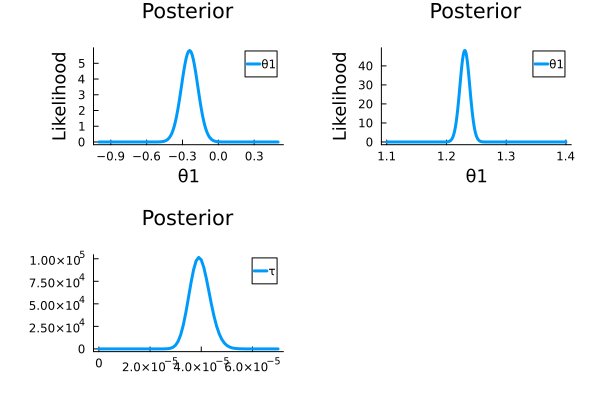

In [55]:
@model function auto_regression(prior_params; N)
    # Prior state
    θ ~ MvNormalMeanCovariance(prior_params[:θ0][1], prior_params[:θ0][2])
    
    # Process noise covariance matrix
    τ ~ Gamma(prior_params[:τ][1], prior_params[:τ][2])
    #τ ~ Beta(1.0, 1.0)
    
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    for i = 1:N
        y[i] ~ NormalMeanPrecision(dot(θ,X[i]), τ)
    end
end

# Prior parameters
M = 2

num_samples = length(past_data[:,1])
history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]

# Define prior parameters
prior_params = Dict(:θ0 => (zeros(M), diageye(M)),
                    :τ  => (1, 1))

# Initialize variational marginal distributions and messages
inits = Dict(:θ => MvNormalMeanCovariance(zeros(M), diageye(M)),
             :τ => Gamma(1, 1))

results = inference(
    model           = auto_regression(prior_params, N=num_samples-M), 
    data            = (y = past_data[:,2][M+1:num_samples], X = history), 
    returnvars      = (θ = KeepLast(), τ = KeepLast()), 
    iterations      = 20,
    constraints     = MeanField(),
    #initmarginals   = (τ = vague(InverseGamma), ), 
    initmarginals = inits,
    initmessages  = inits,
    free_energy     = true
)

# Extract posterior weights 
post_θ = results.posteriors[:θ]
post_τ = results.posteriors[:τ]

post_mode_θ = mode(post_θ)
post_std_θ = std(post_θ)

# Draw contour plots of distributions
θ = 1
x1 = range(-1, step=0.01, stop=0.5)
prior_θ = Normal(post_mode_θ[θ], post_std_θ[θ, θ])
p1a = plot(x1, pdf(prior_θ, x1), xlabel="θ1", ylabel="Likelihood", title="Posterior", label="θ1")

θ = 2
x1 = range(1.1, step=0.001, stop=1.4)
prior_θ = Normal(post_mode_θ[θ], post_std_θ[θ, θ])
p1b = plot(x1, pdf(prior_θ, x1), xlabel="θ1", ylabel="Likelihood", title="Posterior", label="θ1")

x1 = range(0, step=0.000001, stop=0.00007)
p1c = plot(x1, pdf(post_τ, x1), title="Posterior", label="τ")

plot(p1a, p1b, p1c)

In [53]:
# YOUR CODE HERE
@model function auto_regression(μ_θ, Σ_θ; N=1)
    "Bayesian linear regression"
    
    # Allocate data variables
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    # Prior distribution of coefficients
    θ ~ MvNormalMeanCovariance(μ_θ, Σ_θ)
    τ ~ Beta(5.0, 5.0)

    y .~ NormalMeanVariance(θ.*X, τ)
    # for i = 1:N

    #     τ[i] ~ Beta(5.0, 5.0)
    #     # Likelihood of i-th sample
    #     y[i] ~ NormalMeanVariance(dot(θ,X[i]), τ[i]) where { q = MeanField() }
        
    # end
    return y, X, θ, τ
end

# Prior parameters
M = 2
μ_θ, Σ_θ = (zeros(M), diagm(ones(M)))

# Likelihood variance
τ = 1.0;
num_samples = length(past_data[:,1])
dates_num = 1:num_samples

initmarginals = (
    τ = Beta(1.0, 1.0),
)

constraints = @constraints begin
    q(θ,τ) = q(θ)q(τ)
end

# Call inference function
history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]
results = inference(
    model       = auto_regression(μ_θ, Σ_θ, N=num_samples-M),
    data        = (y = past_data[:,2][M+1:num_samples], X = history),
    returnvars  = (θ = KeepLast(), τ = KeepLast()),
    # constraints = constraints,
    # initmarginals = initmarginals,
    iterations      = 20,
    constraints     = MeanField(),
    initmarginals   = (τ = vague(InverseGamma), ),
    free_energy     = true
)

# Extract posterior weights 
post_θ = results.posteriors[:θ]

# Extract estimated weights
θ_MAP = mode(post_θ)

# Report results
println("Coefficients = "*string(θ_MAP))

# Make predictions
num_samples = 11
regression_estimated = [dot(row, θ_MAP) for row in history]

# Visualize observations
scatter(past_data[:,1][M+1:num_samples+M], past_data[:,2][M+1:num_samples+M], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(past_data[:,1][M+1:num_samples+M], regression_estimated[1:num_samples], ribbon=1, color="blue", label="regression", linewidth=2, size=(800,300))

ReactiveMP.RuleMethodError: RuleMethodError: no method matching rule for the given arguments

Possible fix, define:

@rule typeof(*)(:A, Marginalisation) (m_out::NormalMeanVariance, m_in::PointMass, meta::MatrixCorrectionTools.ReplaceZeroDiagonalEntries{TinyHugeNumbers.TinyNumber}) = begin 
    return ...
end



## 2. Predictions & model evaluation

In this model, the posterior predictive distribution becomes:

$$ p(y_{k+1} \mid \bar{y}_{k}, \mathcal{D}) = \int p(y_{k+1} \mid \theta, \tau, \bar{y}_{k}) p(\theta \mid \mathcal{D}) p(\tau \mid \mathcal{D}) \, \mathrm{d}\theta \, \mathrm{d}\tau . $$

This integral is a bit complicated. As such, you are allowed to use a simplified form:

$$ p(y_{k+1} \mid y_{k}, \mathcal{D}) = \int \mathcal{N}(y_{k+1} \mid \theta^{\top} \bar{y}_{k}, \hat{\tau}^{MAP} ) p(\theta \mid \mathcal{D}) \, \mathrm{d}\theta \,  , $$

where $\hat{\tau}^{MAP}$ refers to the most probable value under the posterior distribution, i.e., $\hat{\tau}^{MAP} = \arg\max p(\tau \mid \mathcal{D})$.

Tasks:
- [1pt] Derive the parameters of the simplified posterior predictive distribution and compute the 1-step ahead predictions on the data set. Plot the first 10 predictions (_mean and 1 standard deviation_) along with the data $y_{2:11}$.

---

Note that if you failed to infer a posterior distribution in the previous question, you can still answer this question using a standard normal, $p(\theta) = \mathcal{N}(0,1)$.

Coefficient = [-0.24029110499283166, 1.2307207059494623]


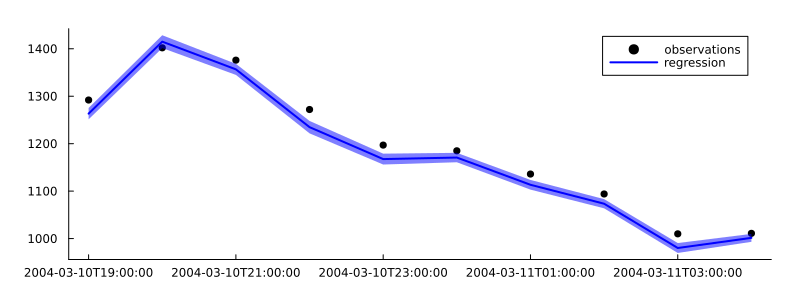

In [56]:
# YOUR CODE HERE
# Extract estimated weights
mθ, Sθ = mean_cov(results.posteriors[:θ])

num_samples = 11

# Report results
println("Coefficient = "*string(mθ))

# Make predictions
#regression_estimated = past_data[:,2][1:num_samples-1] * θ_MAP;
sim_mean = zeros(num_samples-M+1)
sim_stds = zeros(num_samples-M+1)

for t = 1:num_samples-M+1
    y_prev = history[t]
    
    # Compute parameters of posterior
    sim_mean[t] = mθ'*y_prev
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + mode(post_τ)) 
end

# Visualize observations
scatter(past_data[:,1][M:num_samples], past_data[:,2][2:num_samples], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(past_data[:,1][M:num_samples], sim_mean, ribbon=sim_stds, color="blue", label="regression", linewidth=2, size=(800,300))

## 3. Model selection & deployment

Vary the autoregressive model order $M$ and use free energy as a model evaluation criterion. Which model is the best?

Tasks:
- [1pt] Compute the free energies for a given range of $M$ and report the best performing one.
- [1pt] Deploy the best model on future data and visualize 1-step ahead predictions (_mean and 1 standard deviation_).

In [81]:
# YOUR CODE HERE
fe_lowest = Inf
M_best = 1
θ_best = 0
results_best = 0

for M in 1:10
    num_samples = length(past_data[:,1])
    history = [[past_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]

    # Define prior parameters
    prior_params = Dict(:θ0 => (zeros(M), diageye(M)),
                        :τ  => (1, 1))

    # Initialize variational marginal distributions and messages
    inits = Dict(:θ => MvNormalMeanCovariance(zeros(M), diageye(M)),
                :τ => Gamma(1, 1))

    results = inference(
        model           = auto_regression(prior_params, N=num_samples-M), 
        data            = (y = past_data[:,2][M+1:num_samples], X = history), 
        returnvars      = (θ = KeepLast(), τ = KeepLast()), 
        iterations      = 20,
        constraints     = MeanField(),
        #initmarginals   = (τ = vague(InverseGamma), ), 
        initmarginals = inits,
        initmessages  = inits,
        free_energy     = true
    )

    fe = results.free_energy[end]
    println("Model length: ", string(M), ", Free energy: ", string(fe))
    if fe < fe_lowest
        fe_lowest = fe
        M_best = M
        θ_best = θ_MAP
        results_best = results
    end
end

Model length: 1, Free energy: 1313.9559008726897
Model length: 2, Free energy: 1304.593650298431


Model length: 3, Free energy: 1299.4279980294727
Model length: 4, Free energy: 1294.8051405277438


Model length: 5, Free energy: 1289.3552076433343
Model length: 6, Free energy: 1285.9502091167274


Model length: 7, Free energy: 1277.3588533766601
Model length: 8, Free energy: 1272.9664775888973


Model length: 9, Free energy: 1267.9606970171762
Model length: 10, Free energy: 1260.9547352784202


In [82]:
# Load test data
future_data = DataFrame(CSV.File("data/airquality_future.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-19T02:00:00,999.0
2,2004-03-19T03:00:00,961.0
3,2004-03-19T04:00:00,934.0
4,2004-03-19T05:00:00,913.0
5,2004-03-19T06:00:00,969.0
6,2004-03-19T07:00:00,1182.0
7,2004-03-19T08:00:00,1740.0
8,2004-03-19T09:00:00,1819.0
9,2004-03-19T10:00:00,1427.0


Coefficient = [0.1924345575532156, -0.09466679131440436, 0.002422884416496629, 0.1520835130842535, -0.23598809359930684, 0.18765600474502975, -0.050001386137285664, 0.025910661651948885, -0.3529306407344137, 1.171162383610863]


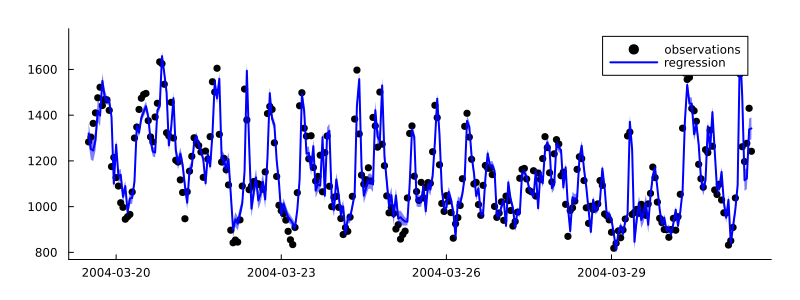

In [84]:
# YOUR CODE HERE
M = M_best
θ = θ_best
mθ, Sθ = mean_cov(results_best.posteriors[:θ])

num_samples = length(future_data[:,1])

# Report results
println("Coefficient = "*string(mθ))

# Make predictions
#regression_estimated = past_data[:,2][1:num_samples-1] * θ_MAP;
sim_mean = zeros(num_samples-M)
sim_stds = zeros(num_samples-M)

history = [[future_data[:,2][i+j] for j in 0:M-1] for i in 1:num_samples-M]

for t = 1:num_samples-M
    y_prev = history[t]
    
    # Compute parameters of posterior
    sim_mean[t] = mθ'*y_prev
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + mode(post_τ)) 
end

# Visualize observations
scatter(future_data[:,1][M+1:num_samples], future_data[:,2][M+1:num_samples], color="black", label="observations", legend=:topright)

# Overlay regression function
plot!(future_data[:,1][M+1:num_samples], sim_mean, ribbon=sim_stds, color="blue", label="regression", linewidth=2, size=(800,300))